# NATURAL LANGUAGE PROCESSING
## Assignment Notebook

### Authors
- Eren Şenoğlu
- Mehmet Emre Akbulut
- Yavuz Samet Topçuoğlu

You can find all the scripts and detailed experiments on the [Github Page](https://github.com/mehmetemreakbulut/YELP-Rating).

### Dataset Explanation

- The dataset used in this project is the Yelp Review Full dataset, which is a large collection of product reviews along with their star ratings. The dataset is publicly available on the Hugging Face datasets repository and can be accessed [here](https://huggingface.co/datasets/yelp_review_full).

- The dataset was introduced in the paper ["Character-level Convolutional Networks for Text Classification"](https://arxiv.org/abs/1509.01626) by Xiang Zhang, Junbo Zhao, and Yann LeCun. The paper explores the use of character-level convolutional networks for text classification tasks.

- The Yelp Review Full dataset is particularly suited for tasks such as star rating prediction and sentiment analysis. Each review in the dataset is associated with a star rating, which can be used as a proxy for the sentiment expressed in the review. The goal of the project is to build a model that can accurately predict the star rating of a review based on its text content.

### Preliminary Analysis 

- Load the dataset.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

- Inspect the dataset.

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})


In [ ]:
# Print the first example in the dataset
print(dataset["train"][0])

{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}


Notice that the dataset consists of 700000 rows in total, 650000 for train and 50000 for test.\
Each sample has :
 - - a 'label', ```int``` type.
 - - a 'text', ```string``` type.

- Convert sets to dataframes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Convert the train dataset to a pandas DataFrame
train_df = pd.DataFrame(dataset["train"])

# Convert the test dataset to a pandas DataFrame
test_df = pd.DataFrame(dataset["test"])

* Visualise collection statistics.

- 1. - Label Distributions

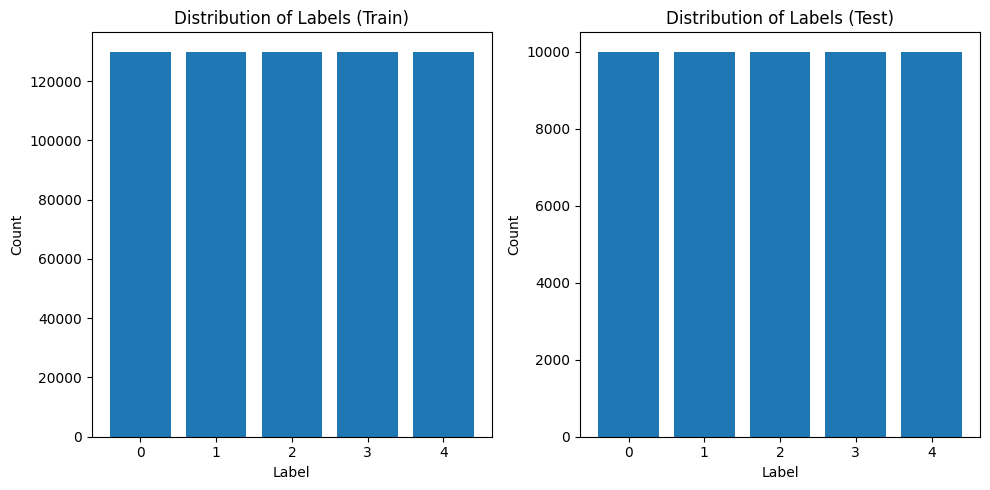

In [ ]:
# Count the occurrences of each label in the train dataset
train_label_counts = train_df["label"].value_counts()

# Count the occurrences of each label in the test dataset
test_label_counts = test_df["label"].value_counts()

# Create subplots for train and test datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the distribution of labels for train dataset
ax1.bar(train_label_counts.index, train_label_counts.values)
ax1.set_xlabel("Label")
ax1.set_ylabel("Count")
ax1.set_title("Distribution of Labels (Train)")

# Plot the distribution of labels for test dataset
ax2.bar(test_label_counts.index, test_label_counts.values)
ax2.set_xlabel("Label")
ax2.set_ylabel("Count")
ax2.set_title("Distribution of Labels (Test)")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

Both in train and test sets, each label has the same amount of data showing that the dataset is <b>evenly distributed</b> across different labels.

- 2. - Document Length and Vocab Size

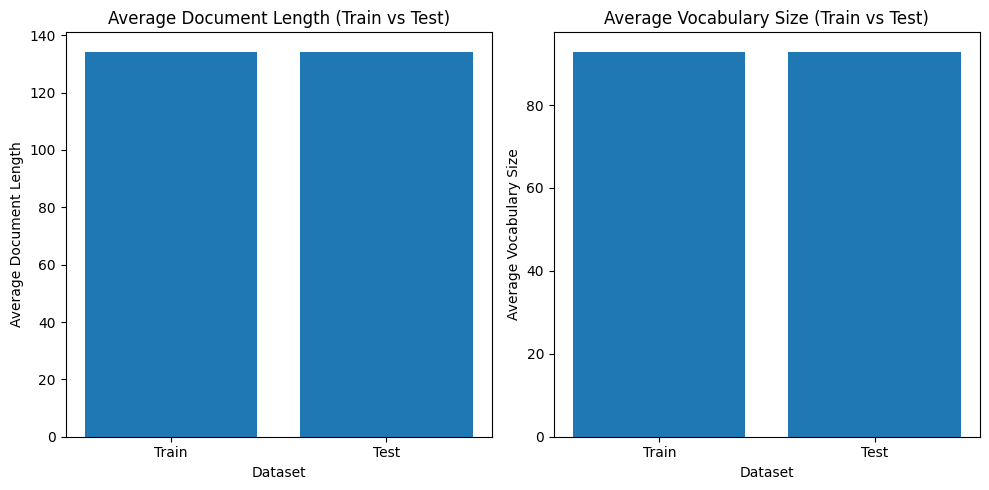

In [ ]:
# Calculate the document length for each document
train_df['doc_length'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['doc_length'] = test_df['text'].apply(lambda x: len(x.split()))

# Calculate the average document length
avg_doc_length_train = train_df['doc_length'].mean()
avg_doc_length_test = test_df['doc_length'].mean()

# Calculate the vocabulary size for each document
train_df['vocab_size'] = train_df['text'].apply(lambda x: len(set(x.split())))
test_df['vocab_size'] = test_df['text'].apply(lambda x: len(set(x.split())))

# Calculate the average vocabulary size
avg_vocab_size_train = train_df['vocab_size'].mean()
avg_vocab_size_test = test_df['vocab_size'].mean()

# Create subplots for average document length and average vocabulary size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the average document length
ax1.bar(['Train', 'Test'], [avg_doc_length_train, avg_doc_length_test])
ax1.set_xlabel("Dataset")
ax1.set_ylabel("Average Document Length")
ax1.set_title("Average Document Length (Train vs Test)")

# Plot the average vocabulary size
ax2.bar(['Train', 'Test'], [avg_vocab_size_train, avg_vocab_size_test])
ax2.set_xlabel("Dataset")
ax2.set_ylabel("Average Vocabulary Size")
ax2.set_title("Average Vocabulary Size (Train vs Test)")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

In [ ]:
print(train_df.describe())
print(test_df.describe())

               label     doc_length     vocab_size
count  650000.000000  650000.000000  650000.000000
mean        2.000000     134.098089      92.712128
std         1.414215     121.396115      67.647099
min         0.000000       1.000000       1.000000
25%         1.000000      52.000000      44.000000
50%         2.000000      99.000000      76.000000
75%         3.000000     175.000000     123.000000
max         4.000000    1052.000000     564.000000
              label    doc_length    vocab_size
count  50000.000000  50000.000000  50000.000000
mean       2.000000    134.290980     92.885480
std        1.414228    121.246345     67.659939
min        0.000000      1.000000      1.000000
25%        1.000000     53.000000     45.000000
50%        2.000000     99.000000     77.000000
75%        3.000000    176.000000    123.000000
max        4.000000   1009.000000    512.000000


As we can see from the dataframe descriptions and the plots above, both in train and test sets, the characteristics of the samples are similar to each other. Average document length in train and test sets are less than a word, whereas average vocab size is similarly has a difference of less than one word in two sets.

- Subsample the data for further analysis.

In [ ]:
# Reduce the size of the train and test datasets
train_df_sample = train_df.sample(n=65000, random_state=1)
test_df_sample = test_df.sample(n=5000, random_state=1)

We will try to explore if a simple clustering will be beneficial for the dataset in the following cells.

- Utilise TF-IDF Vectorizer.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt

# Convert the text into numerical data using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_df_sample['text'])

- Cluster documents using K-Means.
- Attach assigned labels to the data.

In [ ]:
# Use K-means to cluster the documents
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

# Add the cluster labels to the dataframe
train_df_sample['cluster'] = kmeans.labels_

- Reduce dimensionality of the data using TruncatedSVM.

In [ ]:
# Use TruncatedSVD to reduce the dimensionality of the data to 2D
svd = TruncatedSVD(n_components=2, random_state=0)
principalComponents = svd.fit_transform(X)

# Create a DataFrame with the two principal components
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

- Visualise the lower dimension data both with assigned labels and true labels.

- 1. - K-Means Assigned Labels

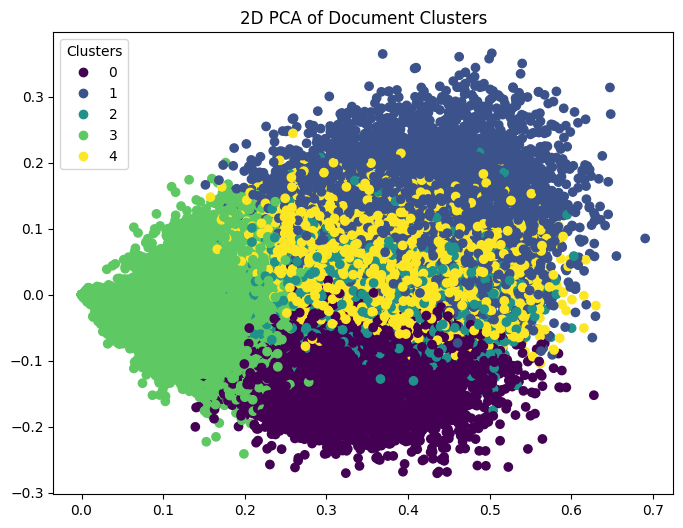

done


In [ ]:
# Visualize the clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=train_df_sample['cluster'])
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('2D PCA of Document Clusters')
plt.show()
print('done')

- 2. - True Labels

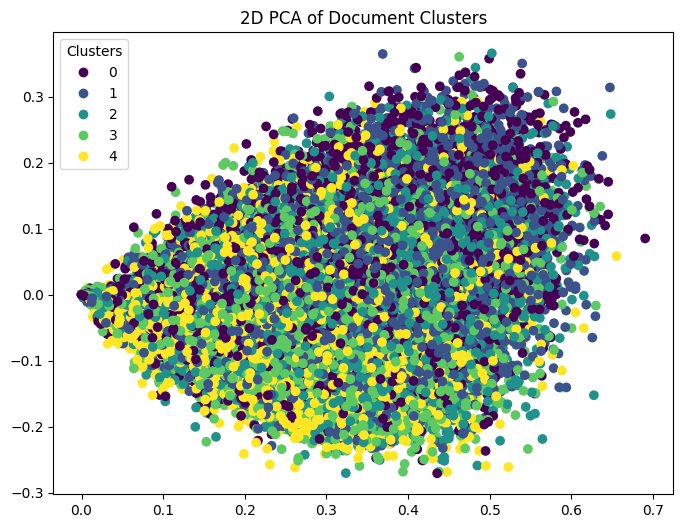

done


In [ ]:
# Visualize the clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=train_df_sample['label'])
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('2D PCA of Document Clusters')
plt.show()
print('done')

As we see from the plots above, a simple clustering with TF-IDF Vectorizer do not reflect the true distribution of labels on the data. 

But why?

To understand it better, let's take a look at the following sample:

In [ ]:
train_df_sample.iloc[0]['text']

'Thank you for all the emails you sent me on my review! I was surprised at how many responses I recieved from people searching for the right dentist..\\nI shared my new dentist information and even got some movie tickets from my dentist for the referrals!\\nI find it funny how since I wrote this review how many people have reviewed with 5 stars... They must have a lot of friends and family! \\nI hope everyone reads my review and picks the right dentist for your needs!\\nHappy Holidays'

Even though this sample has words like:
```thank```, ```surprised```, ```right dentist```, ```5 stars```,  ```happy```;
it is labeled as ```0```. Lowest it can get.

And you can see the irrelevance between the true label and the assigned label from the table below:

In [ ]:
train_df_sample

,label,text,doc_length,vocab_size,cluster
21194,0,Thank you for all the emails you sent me on my...,86,62,3
373117,3,"I, myself, and vietnamese and have tried all d...",129,90,0
470627,2,"3.5 stars.\n\nI have had BFG on my list of \""m...",140,102,4
256672,2,Edamame with truffle salt was great; really li...,27,26,3
465495,3,So I'm running errands before I go back to th...,129,84,4
...,...,...,...,...,...
344887,4,I love this place and their excellent steaks...,8,8,3
580827,3,Been there twice. Great food but buy the wine ...,12,11,3
485230,0,I bought an amazing TaylorMade golf bag for so...,349,217,2
550667,4,Holy crud was this place AMAZING!!!!!! It came...,77,62,1


To be more precise, and show statistics:

In [ ]:
(train_df_sample['label'] == train_df_sample['cluster']).sum()

10575

Out of 65000 train samples, only 10575 (16%) assigned the true label.

- Similarly, let's inspect the wordclouds for the data labeled as ```0``` and ```4```.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

(-0.5, 399.5, 199.5, -0.5)

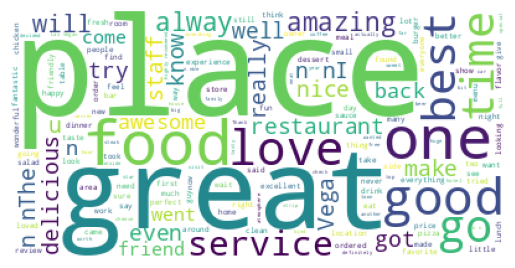

In [ ]:
df5 = train_df_sample[train_df_sample.label == 4]
text5 = ''
for line in df5.text:
    text5 += line + " "
wordcloud5 = WordCloud(background_color="white").generate(text5)
plt.imshow(wordcloud5)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

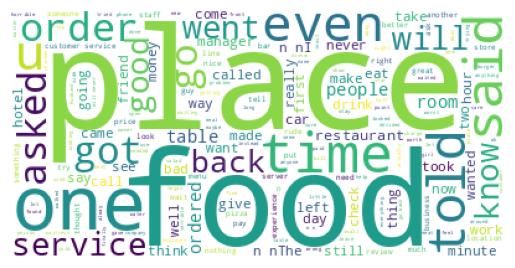

In [ ]:
df1 = train_df_sample[train_df_sample.label == 0]
text1 = ''
for line in df1.text:
    text1 += line + " "
wordcloud1 = WordCloud(background_color="white").generate(text1)
plt.imshow(wordcloud1)
plt.axis("off")

As we can see from the wordclouds, most of the words are in common to both set of data even though they are the exact opposite in terms of labels.

You may not expect a word like ```good``` to be frequently used in samples labeled ```0```.

### Indexing

- Merge train and test sets to allow searching over the entire dataset.

In [ ]:
df = pd.concat([train_df, test_df])
df = df.reset_index(drop=True)

In [ ]:
df

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
...,...,...
699995,0,Just wanted to write a review to chip in with ...
699996,4,Great ambience. Great drinks. Great food. I lo...
699997,3,I have been to the other Monks locations so I ...
699998,1,Don't go here. I know you might want to try i...


- Implement the inverted index from scratch.

In [ ]:
# dictionary = 
# { 
#     word: (
#         number of docs containing word ,
#         {
#             doc_id: [position_list]
#         },
#         number of times word appears in all docs      
#     )
# }

dictionary = {}

- Apply preprocessing to the data (and the query during search). \
\
 Note that this preprocessing is not the same as preprocessing applied before the model trainings. This preprocessing will only be used for search engine.

In [ ]:
import re

def apply_preprocessing(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Replace whitespace with a single space
    text = re.sub(r'\s+', ' ', text)
    
    return text

- Build the inverted index.

In [ ]:
def build_index(df):
    len_df = len(df)
    for id, row in df.iterrows():
        print(f'Processing progress: {id+1}/{len_df} ({(id+1)/len_df*100:.2f}%)', end='\r')
        text = apply_preprocessing(row['text'])

        # Split the text into words and iterate over them
        for index, word in enumerate(text.split()):

            # If the word is already in the dictionary, update the dictionary
            if word in dictionary:
                if id in dictionary[word][1]:
                    dictionary[word][1][id].append(index)   # Update the position list
                else:
                    dictionary[word][1][id] = [index]       # Create the position list
                    dictionary[word][0] += 1            # Update the number of docs containing the word
                dictionary[word][2] += 1                # Update the number of times the word appears in all docs
            
            # If the word is not in the dictionary, add it to the dictionary
            else:
                dictionary[word] = [1, {id: [index]}, 1]    # Create the posting list

build_index(df)

- Save the inverted index to be used for searching.

In [ ]:
import pickle

def save_pickle(dictionary):
    # Save the dictionary to a pickle file
    with open('dictionary.pkl', 'wb') as f:
        pickle.dump(dictionary, f)

save_pickle(dictionary)

In [ ]:
def save_csv(dictionary):
    # Save the dictionary to a csv file
    pd.DataFrame.from_dict(dictionary, orient='index').to_csv('dictionary.csv')

save_csv(dictionary)

### Searching

- Load the inverted index.

In [ ]:
def load_pickle(path):
    with open(path, 'rb') as f:
        inverted_index = pickle.load(f)
    
    return inverted_index

        #please change the path to the location of your inverted index.
path = '/kaggle/input/dictionary/dictionary.pkl'
inverted_index = load_pickle(path)

In [ ]:
type(inverted_index)

dict

Remember that type is dictionary.

- Try to show the first sample that we printed at the beginning of this notebook.

In [ ]:
inverted_index['goldberg']

[12,
 {0: [1],
  1: [111],
  2: [4],
  3: [11],
  4: [5, 35],
  6: [2, 27],
  89695: [169],
  274490: [44],
  383088: [142],
  396714: [191],
  467580: [43],
  467581: [55, 72]},
 15]

Indeed, we get the first sample (indexed 0), the second word (indexed 1) was 'goldberg'.

- Providing the query.

In our search engine, there are two types of querying possible.

- 1. - Phrase Query: \
\
A standard query format providing string to be searched in the index. \
example query: ```"goldberg ate my sandwich"``` 

- 2. - Proximity Query: \
\
An alternative query format providing two words and maximum difference of occurence indexes. \
example query: ```went 5 restaurant```

Please note that from now on, we will include two different outputs for each cell, one for phrase and the other for proximity queries.

In [ ]:
query = input("Enter your query: ")

<div style="font-family: 'Courier New';">
> Enter your query:  "Dr. Goldberg"
<br/>
> Enter your query:  went 5 restaurant
</div>


- Check if the query is ```phrase``` or ```proximity```.
- Apply preprocessing to the query.

In [ ]:
# check if the query is a phrase or proximity query
if query[0] == '"' and query[-1] == '"':
    query = apply_preprocessing(query[1:-1])
    query = query.split()
    q_type = 'PHRASE'
    print('query is a phrase')
else:
    try:
        query = apply_preprocessing(query)
        l = query.split()
        k = int(l[1]) + 1
        query = [l[0], l[2]]
        q_type = 'PROXIMITY'
        print('query is a proximity')
    except:
        print('Try this format: string1 integer string2')

<div style="font-family: 'Courier New';">
> query is a phrase
<br/>
> query is a proximity
</div>


- Take a look at the processed query.

In [ ]:
query

<div style="font-family: 'Courier New';">
> ['dr', 'goldberg']
<br/>
> ['went', 'restaurant']
</div>
<br/>

Queries are tokenized.


- Retrieve the frequency of each token and sort them.

In [ ]:
try:
    freqs = [(inverted_index[word][0], index, word) for index, word in enumerate(query)]
except:
    print('Word not found in dictionary')

freqs

<div style="font-family: 'Courier New';">
> [(4821, 0, 'dr'), (12, 1, 'goldberg')]
<br/>
> [(103945, 0, 'went'), (87175, 1, 'restaurant')]
</div>
<br/>

In [ ]:
freqs.sort()
freqs

<div style="font-family: 'Courier New';">
> [(12, 1, 'goldberg'), (4821, 0, 'dr')]
<br/>
> [(87175, 1, 'restaurant'), (103945, 0, 'went')]
</div>
<br/>

The reason of sorting is that we will start our search using the first element in the `freqs` list, therefore we want it to be more restrictive in terms of document count. 

In [ ]:
FREQ_LENGTH = len(freqs)

- intersect method allows us to find the common documents of two words, given their posting lists.

In [ ]:
def intersect(postings1, postings2, k): #parameter k is the proximity value
    i = 0
    j = 0
    result = []
    while i < len(postings1) and j < len(postings2):
        if postings1[i] - postings2[j] == k:
            result.append(postings1[i])
            i += 1
            j += 1
        elif postings1[i] - postings2[j] < k:
            i += 1
        else:
            j += 1
    return result

- Set the least occuring word as the *static*. Other words in the query will be compared with this word to minimize the search space.

In [ ]:
# choose the first word in the query as the static word to compare with the other words
static = freqs[0][2]
static_postings = inverted_index[static][1]
static_postings_keys = list(static_postings.keys())

static_index = freqs[0][1]

- get_common_postings method utilises the intersect method and returns all common documents' ids including all of the query words.

In [ ]:
# get the common postings list for the query words
def get_common_postings():
    intersection = None

    for i in range(FREQ_LENGTH - 1):

        # set the dynamic word to compare with the static word
        dynamic = freqs[i + 1][2]
        dynamic_postings = inverted_index[dynamic][1]
        dynamic_postings_keys = list(dynamic_postings.keys())

        # get the common postings list for the static and dynamic word
        if intersection is None: intersection = intersect(static_postings_keys, dynamic_postings_keys, 0)
        else:                    intersection = intersect(intersection, dynamic_postings_keys, 0)

        # if there are no common postings, break the loop
        if len(intersection) == 0: break

    return intersection

In [ ]:
intersection = get_common_postings()

- get_ordered_positions allows us to exclude documents that do not have the desired distance between query words.
<br/>
<br/>
- For phrase queries, words must be in order.
- For proximity queries, words must have the desired proximity value at most.

In [ ]:
# get the ordered positions for the query words
def get_ordered_positions():
    orders = {}

    for i in range(FREQ_LENGTH - 1):

        # set the dynamic word to compare with the static word
        dynamic_index = freqs[i + 1][1]
        dynamic = freqs[i + 1][2]
        dynamic_postings = inverted_index[dynamic][1]

        # first iteration
        # proximity queries can only be iterated once
        if len(orders) == 0:
            for id in intersection:
                static_positions = static_postings[id]
                dynamic_positions = dynamic_postings[id]

                if q_type == 'PHRASE':      order = intersect(static_positions, dynamic_positions, static_index - dynamic_index)
                elif q_type == 'PROXIMITY': order = intersect(static_positions, dynamic_positions, k) + intersect(dynamic_positions, static_positions, k)

                if len(order) > 0:
                    orders[id] = order

        # subsequent iterations
        # check if the positions of the query words are in order
        else:
            for id in orders.copy():
                order = orders[id]
                dynamic_positions = dynamic_postings[id]

                # get the positions of the query words that are in order
                update = intersect(order, dynamic_positions, static_index - dynamic_index)

                if len(update) > 0: 
                    orders[id] = update
                else:
                    del orders[id]

        # if there are no wanted positions, break the loop
        if len(orders) == 0: break
    
    return orders

In [ ]:
orders = get_ordered_positions()  

orders list includes the occurance index in the document as well as document id. At the moment, we are only interested in document id, thats why we retrieve the keys.

In [ ]:
# print document ids that contain the query words in the correct order
list(orders.keys())

### note: the output of this cell is omitted because it is too long, but will be referenced in a moment.

In [ ]:
print(intersection == list(orders.keys()))

<div style="font-family: 'Courier New';">
> True
<br/>
> False
</div>
<br/>

As we can see the orders list may or may not differ from the intersection list, depending on the positions of the query words within the text.

- Let's print a sample that is included in the orders list for the given proximity query: 
went 5 restaurant

In [ ]:
print(df[7015])

<div style="font-family: 'Courier New';">
> {'label': 1, 'text': "<b><big>Went</big></b> for a girls night for <b><big>restaurant</big></b>  week. I was feeling crazy so let the waiter pick my meal from the options. He was blah.. All the staff seemed overworked and very tired. The jazz band was the only thing buzzing. He picked the risotto balls they were okay, kinda bland. Then he picked the hanger steak since most everyone at the table got the swordfish. It was cooked rare in he middle which I normally love. I love a good steak. This was not a good steak. Very tough and minimal flavor. Veg casserole was good. The dessert was okay. Had the lemon and blueberry thing. The cookie was TERRIBLE! Like a unflavored overlooked piece of cornbread. What were they thinking. Even our weighted laughed and said yeah it's more for decoration than taste. It was gross.  Don't think I will be back. Disappointed in my queens feast choice. Wish I could go back and choose again. I'm a foodie and disappointed."}
<br/>




This concludes indexing and searching.

### References

- Le, J.P. (2023) Rating prediction from review text with regularization - linear regression vs logistic regression, Medium. Available at: https://medium.com/mitb-for-all/rating-prediction-from-review-text-with-regularization-linear-regression-vs-logistic-regression-df0181fe9c07 (Accessed: 26 May 2024). 
- A step-by-step explanation of principal component analysis (PCA) (no date) Built In. Available at: https://builtin.com/data-science/step-step-explanation-principal-component-analysis (Accessed: 26 May 2024). 
- Özgür, A. (2023) ‘IR-Lec5: Dictionaries’. Istanbul. 
- Özgür, A. (2023) ‘IR-Lec8: Index Construction. Istanbul. 
- Özgür, A. (2023) ‘IR-Lec12: Text Clustering. Istanbul. 